## Setup

In [ ]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
plt.tick_params(left=False, labelleft=False) #remove ticks

import numpy as np
import csv
import math
import random
from BSE import Trader_PRZI
from BSE import market_session
import pandas as pd
from scipy import stats
import pylab 
import scipy.stats as stats
import scikit_posthocs as sp

# reload imports
%reload_ext autoreload
%autoreload 2

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

## Set up for static market session

In [24]:
n_days = 10   
n_hours = 24*n_days
start_time = 0.0
end_time = 60*60*n_hours
duration = end_time - start_time

supRange = (60, 140)
demRange = (60, 140)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supRange], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demRange], 'stepmode': 'fixed'}]

order_interval = 5
order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}


# 4 - 11
k_min = 4
k_max = 12

## Set up for dynamic market session

In [235]:
n_days = 3 
n_hours = 24*n_days
start_time = 0.0
end_time = 60*60*n_hours
duration = end_time - start_time

initial_range = [(60, 140)]

# 1st upward shock  (increase by 40)
first_shock_time = (end_time-start_time) / 3
first_shock_range = [(100, 180)]

# 2nd upwards shock (increase by 100)
second_shock_time = 2*(end_time-start_time) / 3
second_shock_range = [(200, 280)]

supply_schedule = [
    {'from': start_time, 'to': first_shock_time, 'ranges': initial_range, 'stepmode': 'fixed'},
    {'from': first_shock_time, 'to': second_shock_time, 'ranges': first_shock_range, 'stepmode': 'fixed'},
    {'from': second_shock_time, 'to': end_time, 'ranges': second_shock_range, 'stepmode': 'fixed'}
]
demand_schedule = supply_schedule

order_interval = 5
order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

# 4 - 11
k_min = 4
k_max = 12

## Experiment 1: Changing the values of k

### Market session - Keeping F = 0.8 and finding best k value

In [ ]:
trail_id = 'change_k_outputs/change_K'

# fname = trail_id + '_balances.csv'
# tdump = open(fname, 'w')

# for k in range(k_min,k_max):
#     buyers_spec = [('PRDE', 30, {'k': k, 'f_value':0.8, 's_min': -1.0, 's_max': +1.0})] 
#     sellers_spec = buyers_spec
#     traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#     trial_id = trail_id+'_%d' % (k)
#     market_session(trial_id, start_time, end_time, traders_spec,order_sched, tdump, False, True)
#     tdump.flush()    
# tdump.close()  


### Create a plot_csv function to read the pps values from all the strats.csv files (and plot them)

In [21]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#24B99F'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
CB91_Brown= '#98501C'
CB91_Red = '#D43334'

def plot_csv(filename, k_value, f_value):
    df = pd.read_csv( filename,header=None,)
    new_df_buyer = pd.DataFrame()
    new_df_seller = pd.DataFrame()
    
    for row in range(0,len(df.index)):
        b_sum = 0
        s_sum = 0
        for col in range (8, 219 ,7):
            b_sum +=df.loc[row][col]
        new_df_buyer.loc[len(new_df_buyer.index), 0] = b_sum

        for col in range (225, 428,7):
            s_sum +=df.loc[row][col]
        new_df_seller.loc[len(new_df_seller.index), 0] = s_sum
      
    buyers_sma = new_df_buyer.loc[:,0].rolling(5).mean()
    sellers_sma = new_df_seller.loc[:,0].rolling(5).mean()
    total_sma =  buyers_sma + sellers_sma
    
    # Comment out if running compare_pps_different_k() ---------------------------------
    # t_period = list(range(0,len(buyers_sma.index)))
    # plt.plot(t_period, buyers_sma, color=CB91_Green, label='Sum Profit') 
    # plt.plot(t_period, sellers_sma, color=CB91_Blue, label='Buyers Profit') 
    # plt.plot(t_period, total_sma, color=CB91_Pink, label='Sellers Profit') 
    # plt.xlabel("Hours")
    # plt.ylabel("Profit Per Second")
    # plt.title(f"Profit: PRDE with F={f_value} and K={k_value}")
    # plt.legend(frameon=False)
    # plt.grid(linewidth=0.4)
    
    # save figures
    # figure_filename = (f'dynamic_market/figures/change_k/Change_K%02d_F{f_value}.png' % (k_value))
    # plt.savefig(figure_filename)
    # plt.show()

    # -------------------------------------------------------------------------------
    return total_sma.fillna(0).to_numpy()
    

# for k in range(k_min, k_max):
#     plot_csv(trail_id + '_' + str(k) + '_strats.csv', k, 0.8)
    

### Process the results to see if changing k is statistically significant

In [13]:
# plt.xlabel("Hours")
# plt.ylabel("Profit Per Second")
# plt.title("Profit: PRDE with fixed F=0.8 and K=(4-11)")

# def compare_pps_different_k(hours):
#     colors = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet, CB91_Brown, CB91_Red]
    
#     all_k_t_mov_avg = []
#     i=0
#     for k in range(k_min, k_max):
#         k_t_mov_avg = plot_csv(trail_id + '_' + str(k) + '_strats.csv', k, 0.8)
#         all_k_t_mov_avg.append(k_t_mov_avg)
        
#         t_period = list(range(0,hours))
#         plt.plot(t_period, k_t_mov_avg, color=colors[i],linewidth = '0.7', label=f'k = {k}') 
#         print(".")
#         i+=1
    
#     plt.legend(frameon=False)
#     plt.grid(linewidth=0.4)
#     # plt.savefig(f'dynamic_market/figures/change_k/Change_K_F0.8_TOTAL.png')
#     plt.show()
#     return(all_k_t_mov_avg)

# compare_pps_different_k(n_hours)


Plot whisker plots

.
.
.
.
.
.
.
.


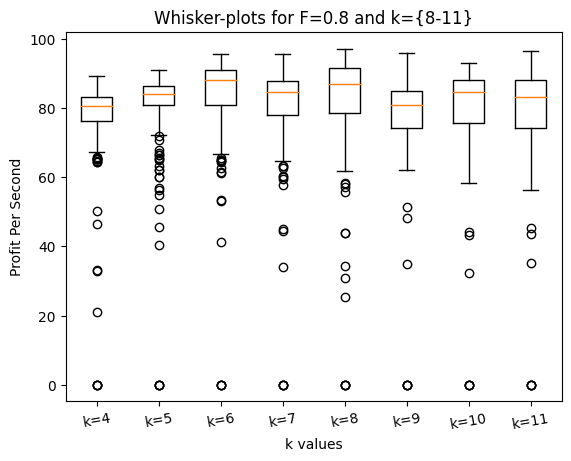

In [18]:
def get_all_avg_change_k():
    all_k_t_mov_avg = []
    i=0
    for k in range(k_min, k_max):
        k_t_mov_avg = plot_csv(trail_id + '_' + str(k) + '_strats.csv', k, 0.8)
        all_k_t_mov_avg.append(k_t_mov_avg)
        print(".")
        i+=1
    return all_k_t_mov_avg

all_k_t_mov_avg = get_all_avg_change_k()

fig1, ax1 = plt.subplots()
ax1.set_title('Whisker-plots for F=0.8 and k={8-11}')

ax1.boxplot(all_k_t_mov_avg)

locs = [1,2,3,4,5,6,7,8]

labels = ['k=4', 'k=5', 'k=6', 'k=7', 'k=8', 'k=9', 'k=10', 'k=11']

plt.xticks(locs,labels, rotation=10)
plt.xlabel("k values")
plt.ylabel("Profit Per Second")
# plt.savefig(f'figures/change_k/whisker_plot.png')

plt.show()

# highest is 6. And its median is above everyone elses boxes but k=8. So if you choose k=6 vs k=n(not 8), then therethere is likely 
# to be a difference between the two groups. 

# However, between k=6 and k=8 both median lines lie between the each others boxes, so we will have to take another step to 
# reach a conclusion about their groups. ????
# OR
# So there is no statistical difference in changing k ???????

Check if data is normally distributed

In [219]:
# (Visual Method) Create a Q-Q plot.
# (Formal Statistical Test) Perform a Shapiro-Wilk Test: if pvalue > 0.05 then data is normally distribution
for i, k in enumerate(all_k_t_mov_avg):
    shapiro_test = stats.shapiro(k)
    print(f"k={i+4}:   {shapiro_test}")
    # stats.probplot(k, dist="norm", plot=pylab)
    ## pylab.savefig(f'figures/change_k/distribution_test/k_{i+4}.png')
    # pylab.show()  
    # print("\n")

# conclusion -> data is not normally distributed, so need to do a non-parametric test

k=4:   ShapiroResult(statistic=0.608230710029602, pvalue=1.45147956154279e-12)
k=5:   ShapiroResult(statistic=0.6455355882644653, pvalue=6.693579718275444e-12)
k=6:   ShapiroResult(statistic=0.5866053700447083, pvalue=6.266257044501566e-13)
k=7:   ShapiroResult(statistic=0.6127657294273376, pvalue=1.7381833819496428e-12)
k=8:   ShapiroResult(statistic=0.6651501655578613, pvalue=1.5641658107634626e-11)
k=9:   ShapiroResult(statistic=0.5941767692565918, pvalue=8.378637952714818e-13)
k=10:   ShapiroResult(statistic=0.504102885723114, pvalue=3.296952758003423e-14)
k=11:   ShapiroResult(statistic=0.594592273235321, pvalue=8.514244539438443e-13)


.

Non-parametric: Kruskal Wallis test

In [222]:
# we have k={4-11} 8 'samples' i.e. sets of sma's
# we want to test to see if they come from the same population sample?

# want to not assume anything about the distribution of the sample -> non-parametric
# mannwhitney doesnt do well for multiple pairwise tests
# nul hypothesis h0: data from 2 samples comes from the same populations
# if calcualted u value less than critical value (from table) for the same u combination,
# usually like 0.01 or 0.05, then reject h0 (so the samples do not come from the same populations)

# mw = stats.mannwhitneyu(all_k_t_mov_avg[0], all_k_t_mov_avg[1])
# mw2 = stats.mannwhitneyu(all_k_t_mov_avg[1], all_k_t_mov_avg[2])
# print(mw)
# print(mw2)

# kruskal wallis test===============================================================================================================
# allows multiple group comparions. Generalised u-test for multiple groups

# Compare all k's
allwh = stats.kruskal(all_k_t_mov_avg[0],all_k_t_mov_avg[1],all_k_t_mov_avg[2],all_k_t_mov_avg[3],all_k_t_mov_avg[4],all_k_t_mov_avg[5],all_k_t_mov_avg[6],all_k_t_mov_avg[7])
print("compare all k's: ", allwh)
# pvalue > 0.05 so reject null hypo, conclude samples do not come from same population
# At least, one population(k) median is different from other populations, so changing k could lead 
# to statistically significant differences in profits

# Sepecifically compare k=6 and k=8
# wh68 = stats.kruskal(all_k_t_mov_avg[2],all_k_t_mov_avg[4])
# print("compare k=6 and k=8: ", wh68)
# the pvalue for k=6 and k=8 is > 0.05 so we accept the null hypothesis. 
# This means the medians are similar. i.e. changing k between 6 and 8 produces no statisticaclly significant differences


compare all k's:  KruskalResult(statistic=75.14736876283965, pvalue=1.3386264163195813e-13)


.

## Experiment 2: Changing the values of F

### Determine top 2 k_values for the next experiment cause doing all would take too long

In [67]:
# print("BASED ON MEAN ==========================================================================================================================")
# all_means = []
# for i in range(len(all_k_t_mov_avg)):
#     mean_i = np.mean(all_k_t_mov_avg[i])
#     all_means.append(mean_i)

# # Best k for f=0.8
# maxMean = max(all_means)
# maxK = np.argmax(all_means) + 4

# print(f"Best_k overall for f=0.8: {maxK}")
# print(f"Mean: {maxMean}")

# # Top 4 performning k's for f=0.8
# top3_means_and_k = sorted(((value, index) for index, value in enumerate(all_means)), reverse=True)[:3]
# top3_k = []
# for n in top3_means_and_k:
#     top3_k.append(n[1]+4)

# print("Top 3 performing k values for f=0.8:", top3_k)


print("\nBASED ON MEDIAN ==========================================================================================================================")
all_medians = []
for i in range(len(all_k_t_mov_avg)):
    mean_i = np.median(all_k_t_mov_avg[i])
    all_medians.append(mean_i)

maxMedian = max(all_medians)
maxk = np.argmax(all_medians) + 4

print(f"Best_k overall for f=0.8: {maxK}")
print(f"Median: {maxMedian}")

# Top 4 performning k's for f=0.8 --------
top2_medians_and_k = sorted(((value, index) for index, value in enumerate(all_medians)), reverse=True)[:2]
top2_k_medians = []

for n in top2_medians_and_k:
    top2_k_medians.append(n[1]+4)

print("Top 2 performing k values for f=0.8:", top2_k_medians)

# Don't ignore k=8 cause we just proved that there is no difference between k=6 and k=8 for f=0.8 only


BASED ON MEDIAN ==========================================================================================================================
Best_k overall for f=0.8: 6
Median: 88.0890661
Top 2 performing k values for f=0.8: [6, 8]


### Market session - Change f=(0-2) for top 3 k values

In [ ]:
# trail_id = 'change_f_for_top3_k_outputs/change'
trail_id = 'change_f_for_top2_k_outputs/change'

# fname = trail_id + '_F_top3_K_balances.csv'
# tdump = open(fname, 'w')

# top2_k = [6, 8]

# for f in np.arange(0.0,2.0,0.1):
#     for k in top2_k:      # k = 6,8
#         buyers_spec = [('PRDE', 30, {'k': k, 'f_value':f, 's_min': -1.0, 's_max': +1.0})] 
#         sellers_spec = buyers_spec
#         traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#         trial_id = trail_id+f'_K%02d_F{f}' % (k)
#         market_session(trial_id, start_time, end_time, traders_spec,order_sched, tdump, False, True)
#         tdump.flush()
    
# tdump.close()    


### Use plot_csv function to read the pps values from all the strats.csv files 

In [27]:
total_F_k6_sma_array = []
total_F_k8_sma_array = []
# total_F_k7_sma_array = []

for F in np.arange(0.0, 2.0, 0.1):
    k_value="06"
    f_value = (round(F,1))
    F_k_sma_array = plot_csv(trail_id + '_K' + k_value + '_F'+str(f_value)+'_strats.csv', 6, f_value)
    total_F_k6_sma_array.append(F_k_sma_array)
    

for F in np.arange(0.0, 2.0, 0.1):
    k_value="08"
    f_value = (round(F,1))
    F_k_sma_array = plot_csv(trail_id + '_K' + k_value + '_F'+str(f_value)+'_strats.csv', 8, f_value)
    total_F_k8_sma_array.append(F_k_sma_array)

# for F in np.arange(0.0, 2.0, 0.1):
#     k_value="07"
#     f_value = (round(F,1))
#     F_k_sma_array = plot_csv(trail_id + '_K' + k_value + '_F'+str(f_value)+'_strats.csv', 7, f_value)
#     total_F_k7_sma_array.append(F_k_sma_array)



### Process the results to see if changing F is statistically significant

Whisker plots

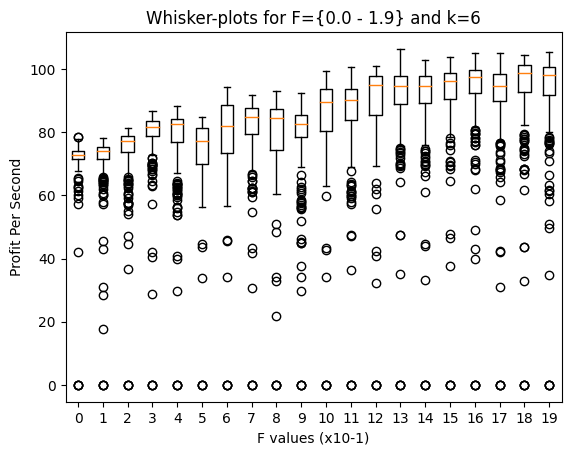

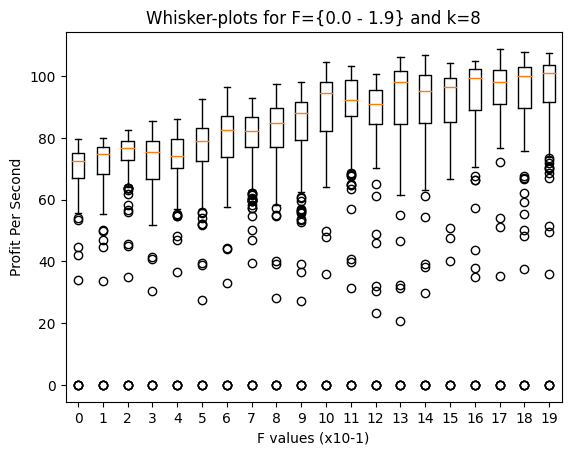

In [32]:
def whisker_plt_F_value(array, k):
    fig1, ax1 = plt.subplots()
    ax1.set_title('Whisker-plots for F={0.0 - 1.9} and k='+ str(k))

    ax1.boxplot(array)
    locs = range(1,21)
    labels = range(0,20)
    plt.xticks(locs,labels)
    
    plt.xlabel("F values (x10-1)")
    plt.ylabel("Profit Per Second")
    plt.savefig(f'figures/change_F/whisker_plot_k{k}.png')
    plt.show()

whisker_plt_F_value(total_F_k6_sma_array, 6)
whisker_plt_F_value(total_F_k8_sma_array, 8)

# Can eyeball that f={1.7-1.9) produces the most pps for each k=6,8,7
# For k=6. f=1.8 median is above every other box except for F=1.5,1.6,1.7,1.9 -> further testing is needed
    # meaning apart from those exceptions, f=1.8 is likely to peform better -> more profit
    
# For k=8. f=1.9 median is above every other box except for F=1.3,1.6,1.7,1.8 -> further testing is needed
# meaning apart from those exceptions, f=1.9 is likely to peform better -> more profit
 
# we can perform a Kruskall Wallis test on all the groups and then a dunn test to see sepcifically which pairing of F values produce results
# that are/are not statistically different


Determine top F_value for each k_value

In [56]:
def find_top_F_values(array, k):
#     print("BASED ON MEAN ==========================================================================================================================")
#     all_means = []
#     for i in range(len(array)):
#         mean_i = np.mean(array[i])
#         all_means.append(mean_i)

#     maxMean = max(all_means)
#     maxF = np.argmax(all_means)/10

#     print(f"Best_F overall for k={k}: {maxF}")
#     print(f"Mean: {maxMean}")

#     top3_means_and_F = sorted(((value, index) for index, value in enumerate(all_means)), reverse=True)[:3]
#     top3_F = []
#     for n in top3_means_and_F:
#         top3_F.append(n[1]/10)

#     print(f"Top 3 performing F values for k={k}:", top3_F)


    print("BASED ON MEDIAN ===========================================================================================================")
    all_medians = []
    for i in range(len(array)):
        mean_i = np.median(array[i])
        all_medians.append(mean_i)

    maxMedian = max(all_medians)
    maxF = np.argmax(all_medians)/10

    print(f"Best_F overall for k={k}: {maxF}")
    print(f"Median: {maxMedian}")

    top3_medians_and_F = sorted(((value, index) for index, value in enumerate(all_medians)), reverse=True)[:3]
    top3_F_medians = []
    for n in top3_medians_and_F:
        top3_F_medians.append(n[1]/10)

    print(f"Top 3 performing F values for k={k}:", top3_F_medians)
    print("\n")

find_top_F_values(total_F_k6_sma_array, 6)
find_top_F_values(total_F_k8_sma_array, 8)
# find_top_F_values(total_F_k7_sma_array, 7)

# F = 1.7-1.9 seems to be the best value

# Best combo so far -> K=8, F=1.9

BASED ON MEDIAN ===========================================================================================================
Best_F overall for k=6: 1.8
Median: 98.7694491
Top 3 performing F values for k=6: [1.8, 1.9, 1.6]


BASED ON MEDIAN ===========================================================================================================
Best_F overall for k=8: 1.9
Median: 100.95199699999999
Top 3 performing F values for k=8: [1.9, 1.8, 1.6]




Check if data is normally distributed

In [54]:
# (Visual Method) Create a Q-Q plot.
# (Formal Statistical Test) Perform a Shapiro-Wilk Test: if pvalue > 0.05 then data is normally distribution

def normal_distr_test(array, k):
    print(f"\nk={k} ==========================================================================================================================")
    for i, F in enumerate(array):
        shapiro_test = stats.shapiro(F)
        print(f"F={i/10}:   {shapiro_test}")
        
        # stats.probplot(F, dist="norm", plot=pylab)
        # plt.title(f"Q-Q plot F={f_value} and K={k_value}")
        # plt.grid(linewidth=0.4)
        # pylab.savefig(f'figures/change_F/distribution_test/k{k}_F{i/10}.png')
        # pylab.show()  
        # print("\n")
    

normal_distr_test(total_F_k6_sma_array, 6)
# normal_distr_test(total_F_k8_sma_array, 8)

# pvalue < 0.05 so data isn not normally distributed -> do KW test to determine if changing F is statistically significant


k=6 ==========================================================================================================================
F=0.0:   ShapiroResult(statistic=0.3372429609298706, pvalue=1.2701517612883542e-28)
F=0.1:   ShapiroResult(statistic=0.4391409158706665, pvalue=8.799221855911447e-27)
F=0.2:   ShapiroResult(statistic=0.4938989281654358, pvalue=1.1090880195985183e-25)
F=0.3:   ShapiroResult(statistic=0.4478400945663452, pvalue=1.29861172881835e-26)
F=0.4:   ShapiroResult(statistic=0.5852047801017761, pvalue=1.2781441508474732e-23)
F=0.5:   ShapiroResult(statistic=0.6295137405395508, pvalue=1.723223985857546e-22)
F=0.6:   ShapiroResult(statistic=0.7543408274650574, pvalue=1.2473917758499925e-18)
F=0.7:   ShapiroResult(statistic=0.5777068138122559, pvalue=8.40812917856152e-24)
F=0.8:   ShapiroResult(statistic=0.6568129062652588, pvalue=9.660223533042349e-22)
F=0.9:   ShapiroResult(statistic=0.6141834259033203, pvalue=6.827462392588125e-23)
F=1.0:   ShapiroResult(statistic=0.65892

Non-parametric: Kruskal Wallis test

In [66]:
# two sided by default
# Null hypothesis: Two groups have equal median
# Alternative hypothesis: Two groups does not have equal median
# mw01 = stats.mannwhitneyu(total_F_k6_sma_array[0], total_F_k6_sma_array[1])
# mw12 = stats.mannwhitneyu(total_F_k6_sma_array[1], total_F_k6_sma_array[2])

# Null hypothesis: Populations medians are equal
# Alternative hypothesis: At least, one population median is different from other populations
# kw6 = stats.kruskal(
#     total_F_k6_sma_array[0],total_F_k6_sma_array[1],total_F_k6_sma_array[2],
#     total_F_k6_sma_array[3],total_F_k6_sma_array[4],total_F_k6_sma_array[5],
#     total_F_k6_sma_array[6],total_F_k6_sma_array[7],total_F_k6_sma_array[8],
#     total_F_k6_sma_array[9],total_F_k6_sma_array[10],total_F_k6_sma_array[11],
#     total_F_k6_sma_array[12],total_F_k6_sma_array[13],total_F_k6_sma_array[14],
#     total_F_k6_sma_array[15],total_F_k6_sma_array[16],total_F_k6_sma_array[17],
#     total_F_k6_sma_array[18],total_F_k6_sma_array[19])

kw6 = stats.kruskal(
    total_F_k6_sma_array[15],total_F_k6_sma_array[16],total_F_k6_sma_array[17],
    total_F_k6_sma_array[18],total_F_k6_sma_array[19])

kw8 = stats.kruskal(
    total_F_k8_sma_array[0],total_F_k8_sma_array[1],total_F_k8_sma_array[2],
    total_F_k8_sma_array[3],total_F_k8_sma_array[4],total_F_k8_sma_array[5],
    total_F_k8_sma_array[6],total_F_k8_sma_array[7],total_F_k8_sma_array[8],
    total_F_k8_sma_array[9],total_F_k8_sma_array[10],total_F_k8_sma_array[11],
    total_F_k8_sma_array[12],total_F_k8_sma_array[13],total_F_k8_sma_array[14],
    total_F_k8_sma_array[15],total_F_k8_sma_array[16],total_F_k8_sma_array[17],
    total_F_k8_sma_array[18],total_F_k8_sma_array[19])

# print(mw01)
# print(mw12)
print("\n")
print(f"k=6: {kw6}" )
# print(f"k=8: {kw8}" )

# pvalues < 0.05 so there are significant differences in pps for different values of F
# i.e. at least one of the medians is not from the same population



k=6: KruskalResult(statistic=42.576326997442926, pvalue=1.2669000333755751e-08)


SIDE: Dunns test: establish which groups are distinct If the Kruskal-Wallis test yields statistically significant findings

In [60]:
# Method for adjusting p values:
# fdr_by = Benjamini/Hochberg (non-negative)

p_values= sp.posthoc_dunn(total_F_k6_sma_array, p_adjust = 'fdr_by')
p_values > 0.05

# False = reject H0 = groups are statistically significant. medians not similar
# True  = accept H0 == groups are NOT statistically significant. medians similar

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
5,False,False,False,True,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False
6,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
8,False,False,False,True,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
9,False,False,False,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False
10,False,False,False,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False


## Top 2 best (k,F) combo and perform balanced group test - Can't really distringuish between the different traders in the _strats.csv files, so ignore for now

Can't really distringuish between the different traders in the _strats.csv files, so ignore for now

In [183]:
# k=6 F=1.7 median = 89
# k=6 F=0.8 median = 88

n_days = 3 
n_hours = 24*n_days
start_time = 0.0
end_time = 60*60*n_hours
duration = end_time - start_time

# Perfect elasticity
supRange = (60, 60)
demRange = (140, 140)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supRange], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demRange], 'stepmode': 'fixed'}]

order_interval = 5
order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

# 4 - 11
k_min = 4
k_max = 12

In [198]:
trail_id = 'balancedG_outputs/'
k_value = 6
f_value1 = 0.8
f_value2 = 1.7

# fname = trail_id + '_balances.csv'
# tdump = open(fname, 'w')

# buyers_spec = [('PRDE', 15, {'k': 6, 'f_value':f_value1, 's_min': -1.0, 's_max': +1.0}),
#               ('PRDE', 15, {'k': 6, 'f_value':f_value2, 's_min': -1.0, 's_max': +1.0})] 
# sellers_spec = buyers_spec
# traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

# trial_id = trail_id+'k6_f0.8_vs_f1.7'
# market_session(trial_id, start_time, end_time, traders_spec,order_sched, tdump, False, True)

# tdump.flush()
# tdump.close()    

Create function for reading in the csv files for the balanced_group experiment

.